1.

In [64]:
import os
import time
from pathlib import Path
import numpy as np
import pickle
import matplotlib.animation as manimation
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, Matern, DotProduct
from numpy import interp

2.

In [65]:
path = 'G:\\My Drive\\SHI\\2024' 
os.chdir(path)
objects = []
# step  level j  i  w  h  dx 
# 0     1     2  3  4  5  6 
with (open("patches.pkl", "rb")) as openfile:
    while True:
        try:
            objects.append(pickle.load(openfile))
        except EOFError:
            break
a = objects[0]
print(a.shape)
print(a[0,:])

(22624, 7)
[0.00000e+00 1.00000e+00 0.00000e+00 0.00000e+00 3.20000e+01 3.20000e+01
 3.90625e-03]


In [66]:
step = 300
for box in range(a.shape[0]):
    if int(a[box,0]) == step and int(a[box,1]) == 2:   # level 1 box
        print(a[box,2:4])

h: 0.00390625
mesh: 129,257
Z dim: (1001, 257, 129)
ZZ dim: (257, 129)
ZZ.T dim: (129, 257)


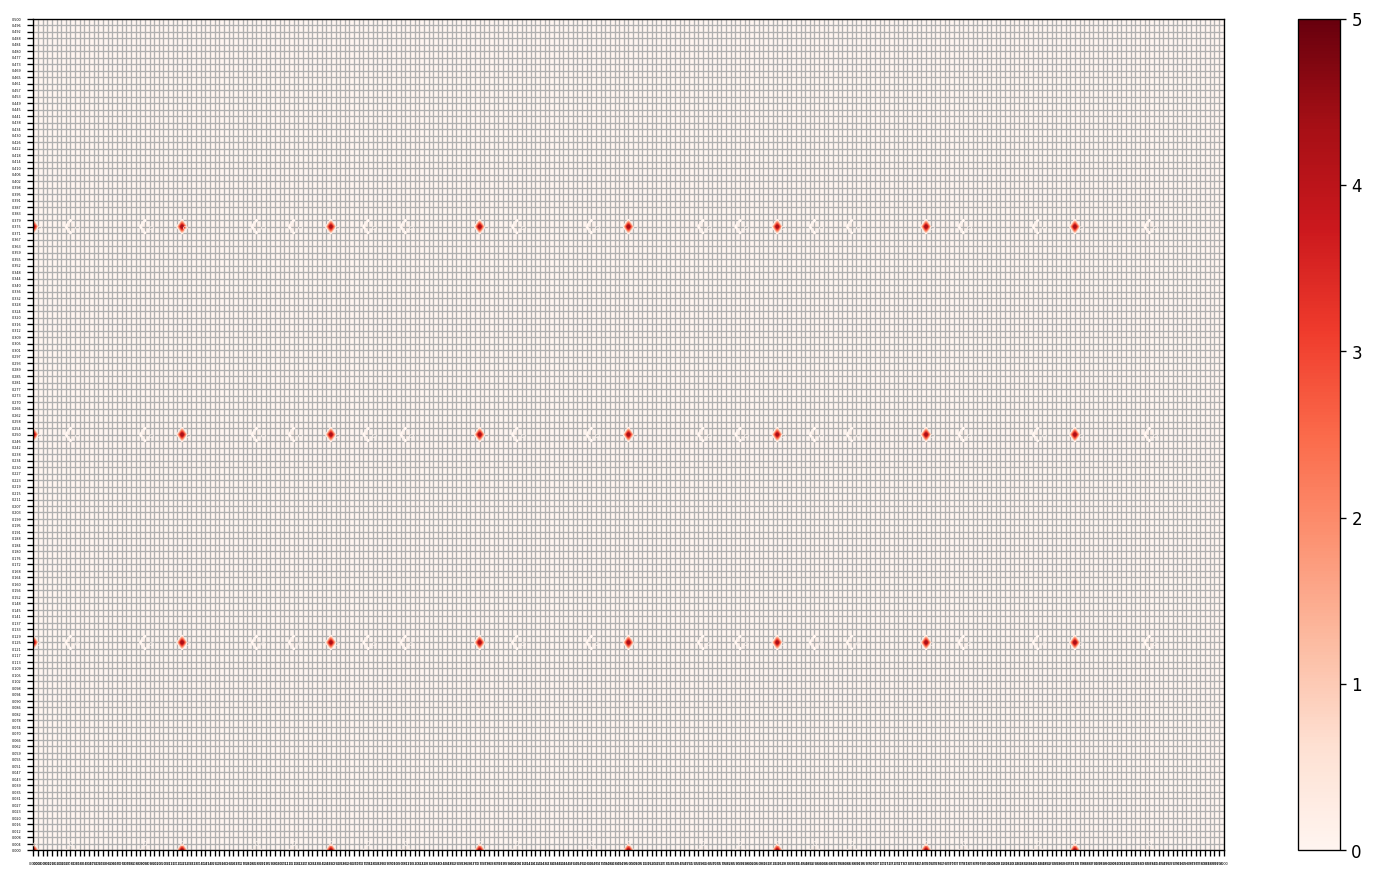

In [67]:
x_min = 0.0 
x_max = 1.0
y_min = 0.0 
y_max = 0.5
coarseFactor = 1
factor = 1
h = 0
steps = 1001
for box in range(a.shape[0]):
    if int(a[box,1]) == 1:   # level 1 box
        if h == 0:
            h = a[box,6]
            print(f'h: {h}')
            xx, yy = np.meshgrid(np.arange(x_min, x_max+h, coarseFactor*h), np.arange(y_min, y_max+h, coarseFactor*h))
            rows = xx.shape[0]
            cols = xx.shape[1]
            print(f'mesh: {rows},{cols}')
            Z = np.zeros((steps,cols,rows))
        # step  level i  j  w  h  dx    
        # 0     1     2  3  4  5  6 
        Z[int(a[box,0]),int(a[box,2]),int(a[box,3])] += 1
fontSize = 4
norm = colors.Normalize(0, 5)
cmap = 'Reds'
fig = plt.figure(figsize=(16*factor, 9*factor), dpi=(1920/16)) #  72 is the nominal DPI
print(f'Z dim: {Z.shape}')
ZZ = np.sum(Z, axis=0)
print(f'ZZ dim: {ZZ.shape}')
print(f'ZZ.T dim: {ZZ.T.shape}')
plot = plt.pcolormesh(xx, yy, ZZ.T, cmap=cmap, shading='nearest')
cset = plt.contour(xx, yy, ZZ.T, cmap=cmap)
plt.clabel(cset, inline=True, fontsize = fontSize)
major_ticks = np.arange(x_min, x_max+h, coarseFactor*h)
ax = plt.gca()
ax.set_xticks(major_ticks)
ax.set_yticks(major_ticks)
ax.tick_params(axis='both', which='major', labelsize=2)
ax.tick_params(axis='both', which='minor', labelsize=2)
ax.grid(which='both')
plt.axis([x_min, x_max, y_min, y_max])
fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
plt.show()

C:\Users\paoli\AppData\Local\Temp\ipykernel_21432\2312580006.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(16*factor, 9*factor), dpi=(1920/16)) #  72 is the nominal DPI


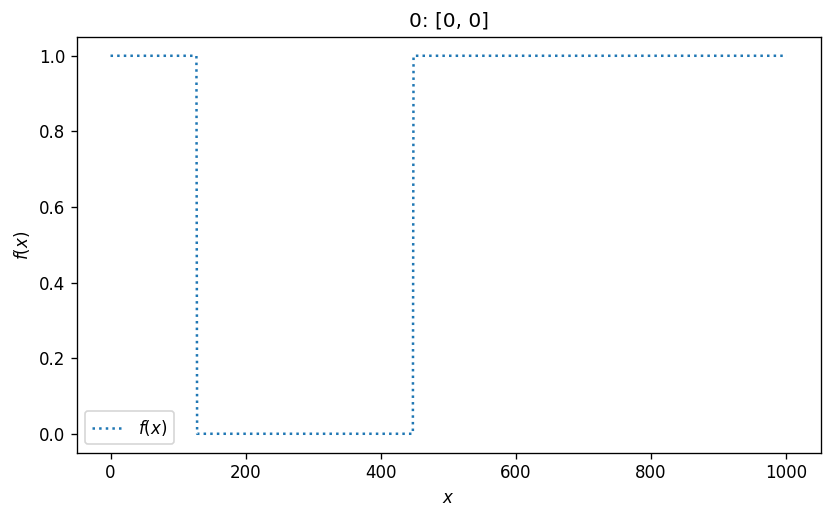

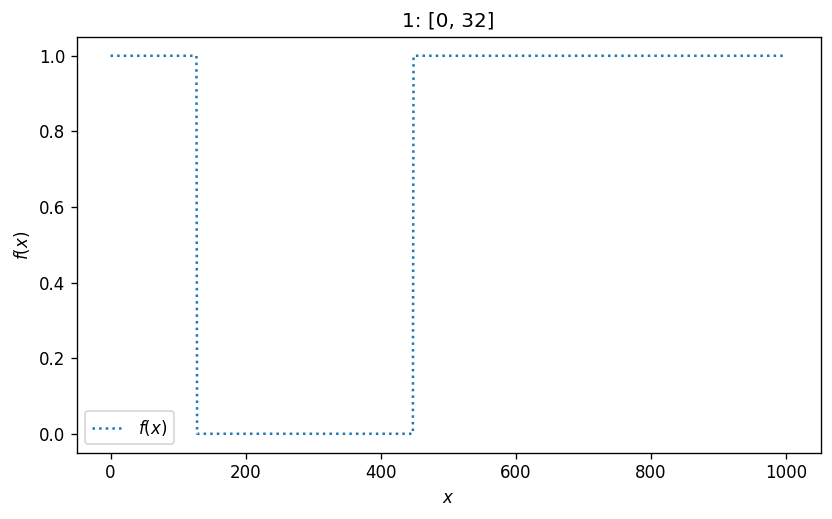

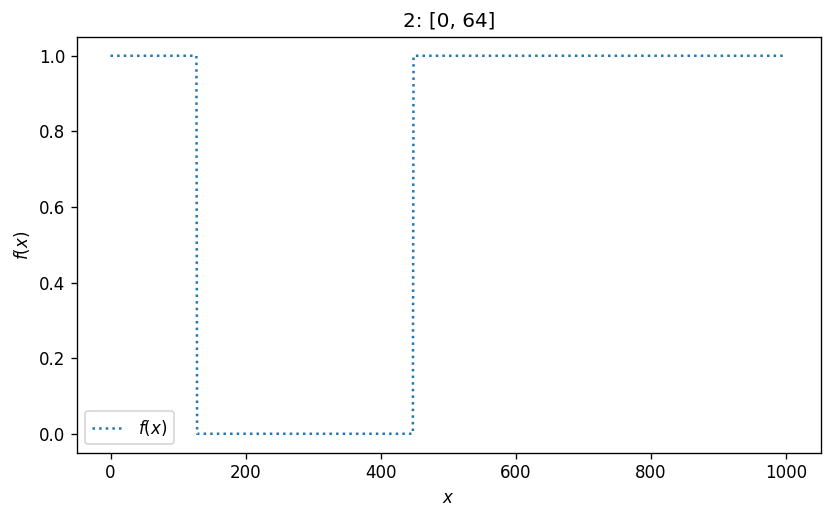

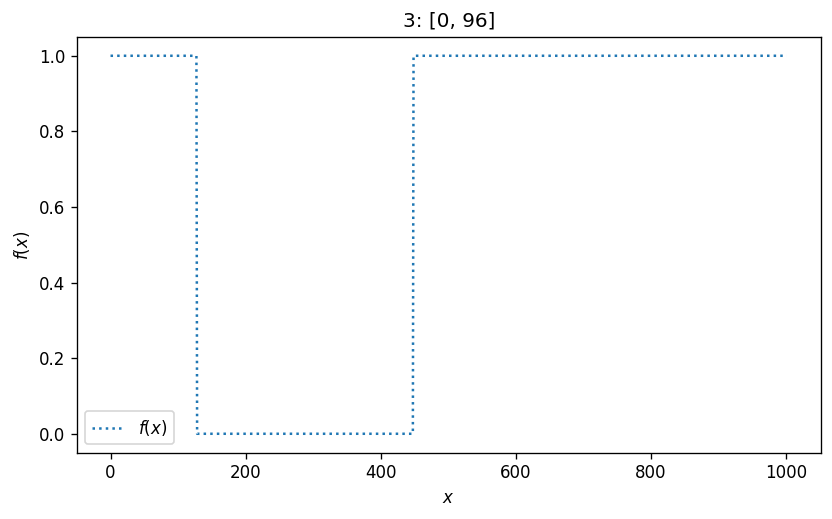

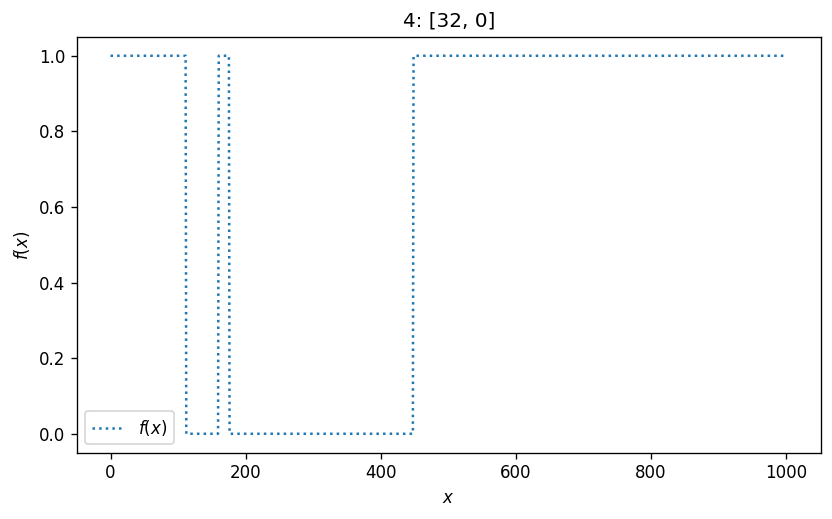

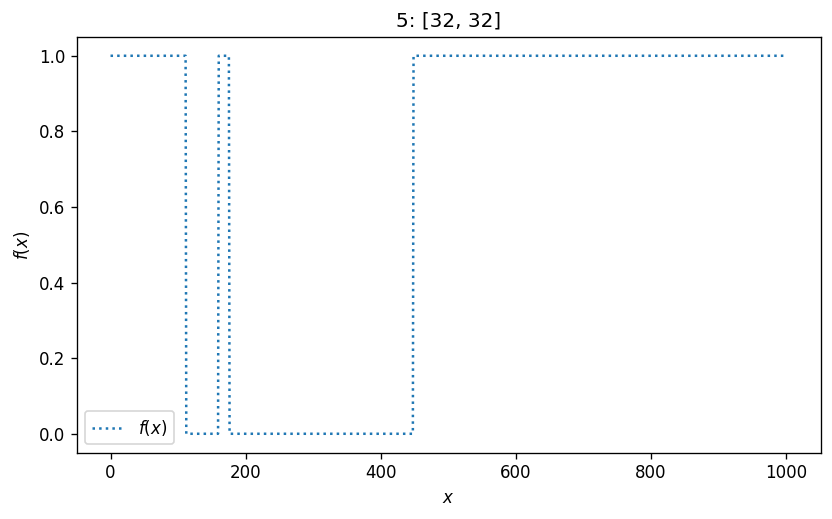

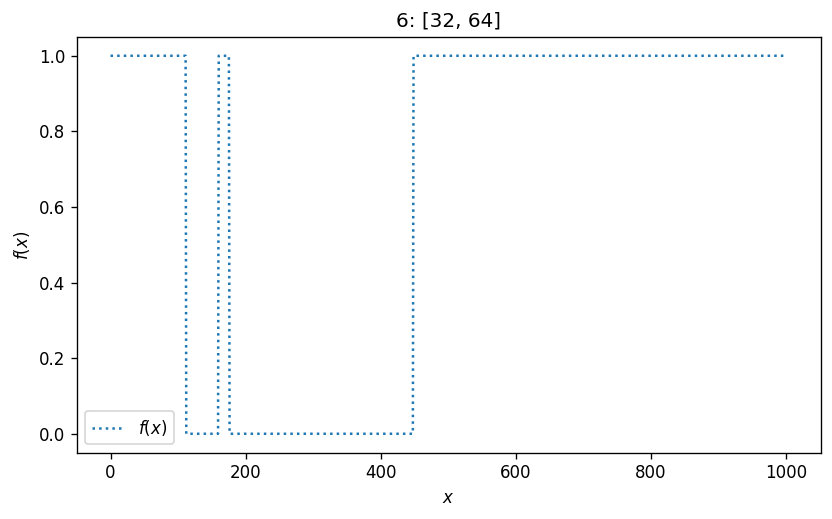

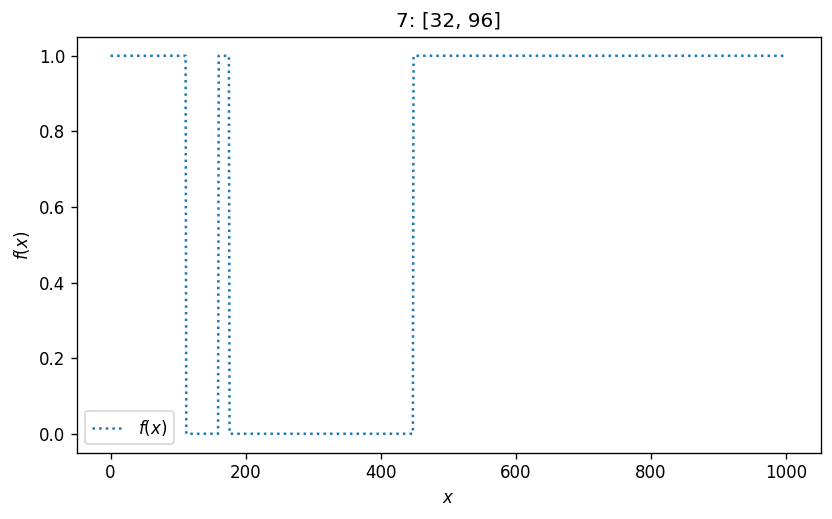

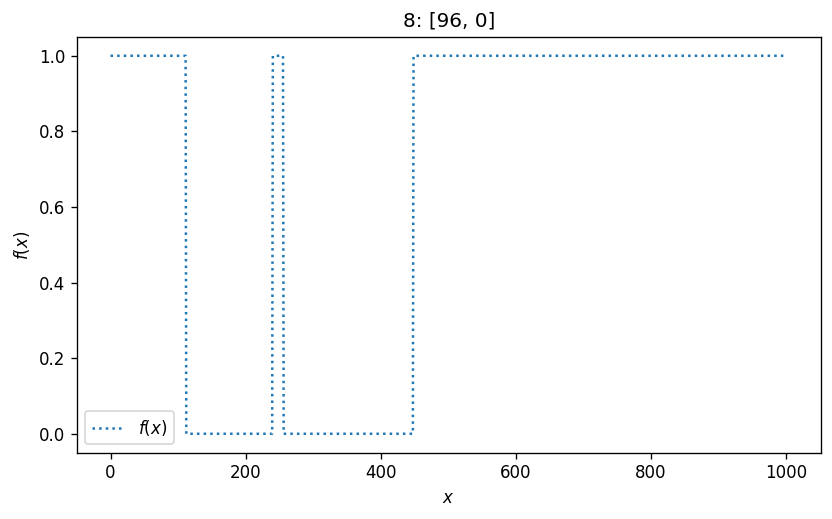

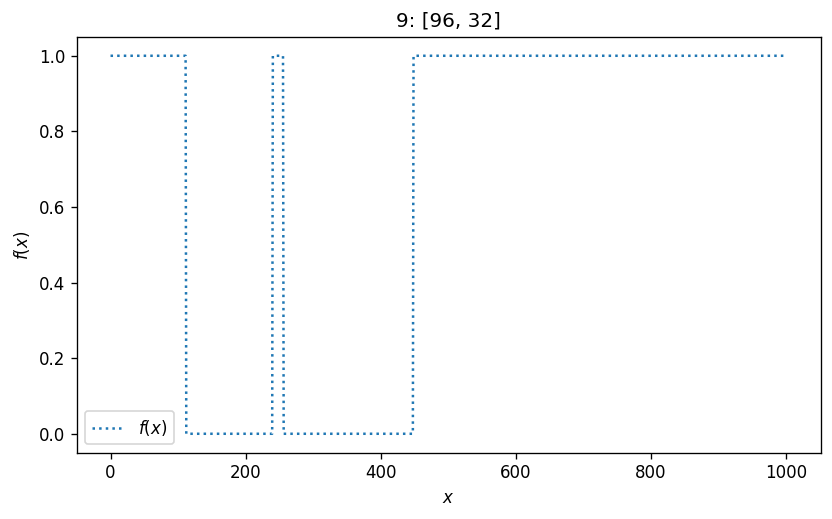

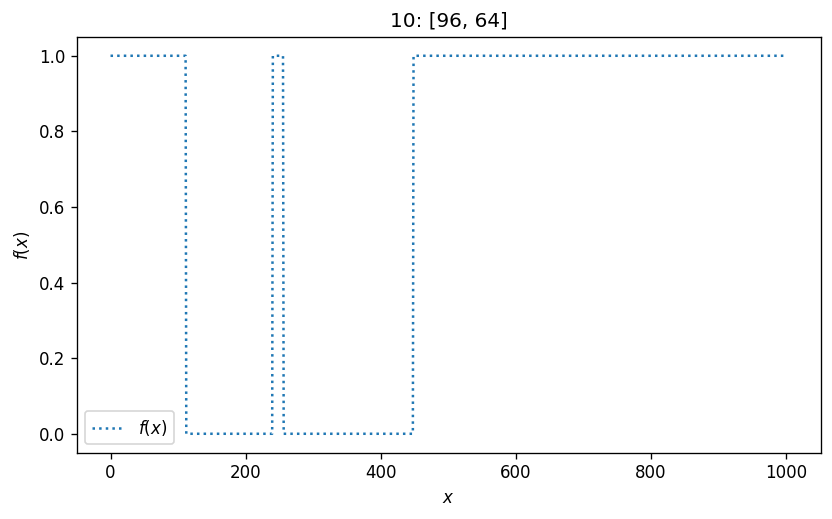

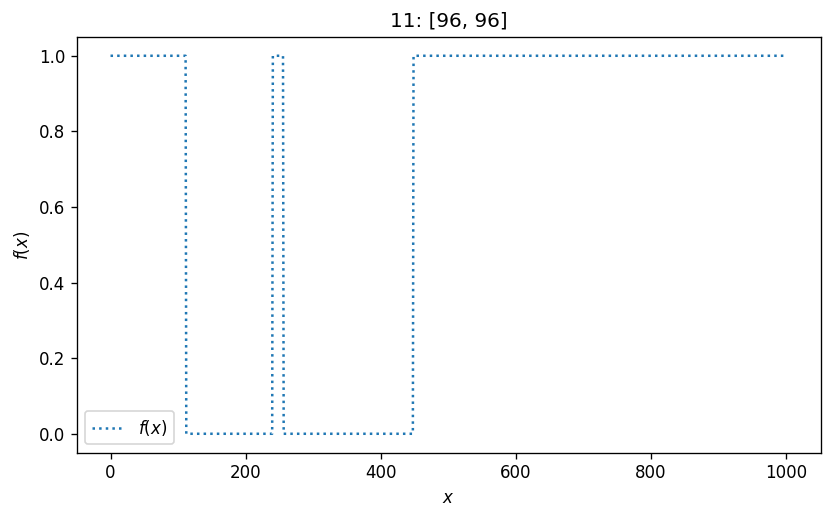

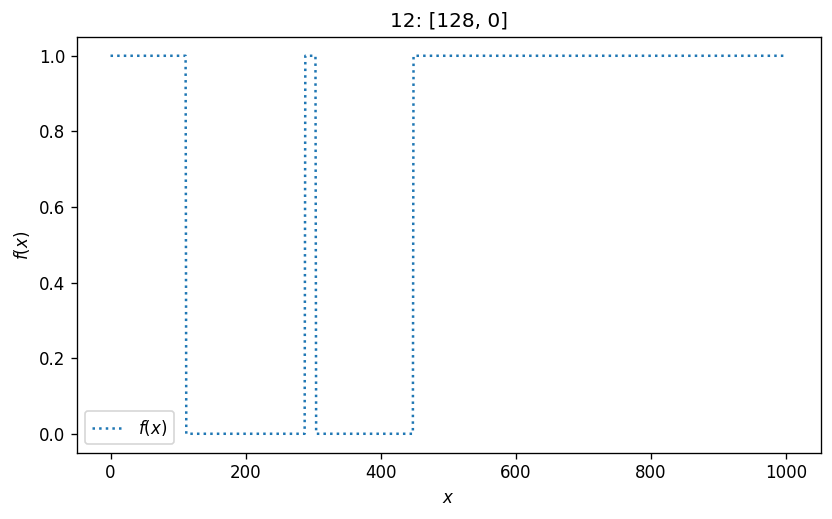

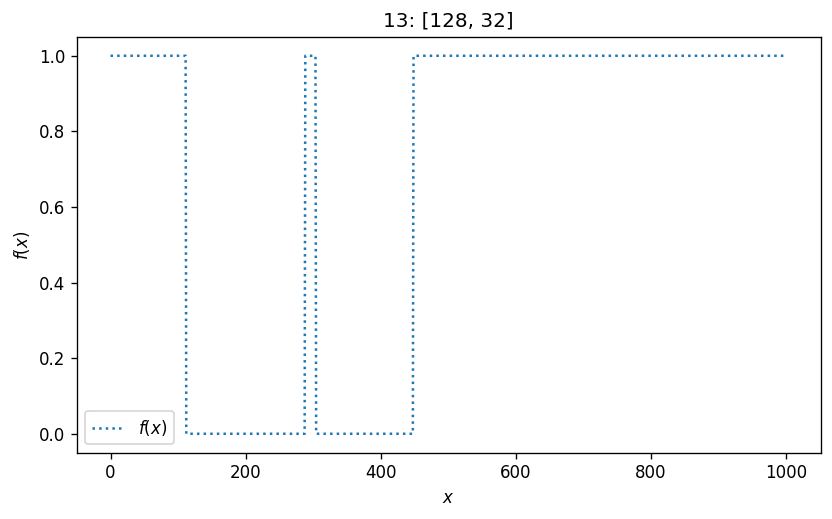

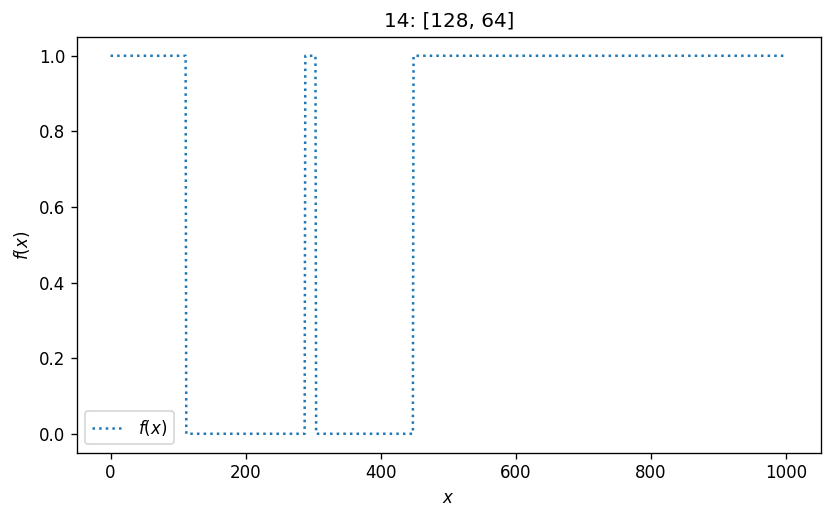

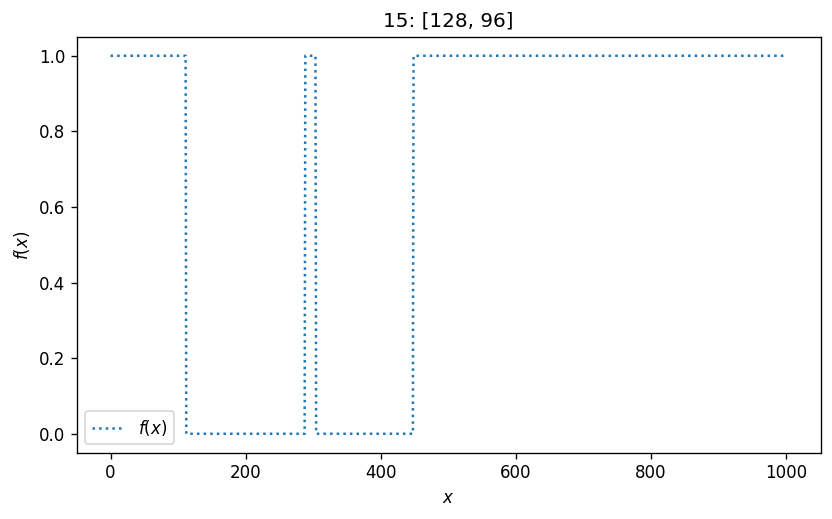

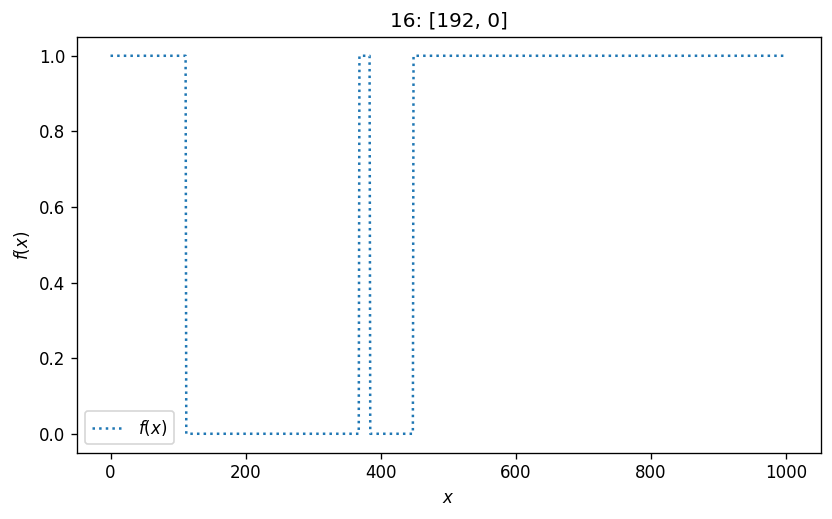

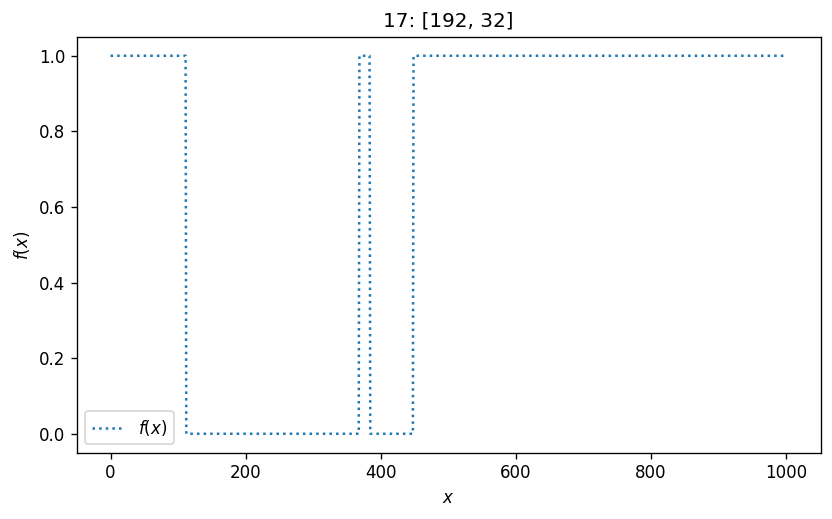

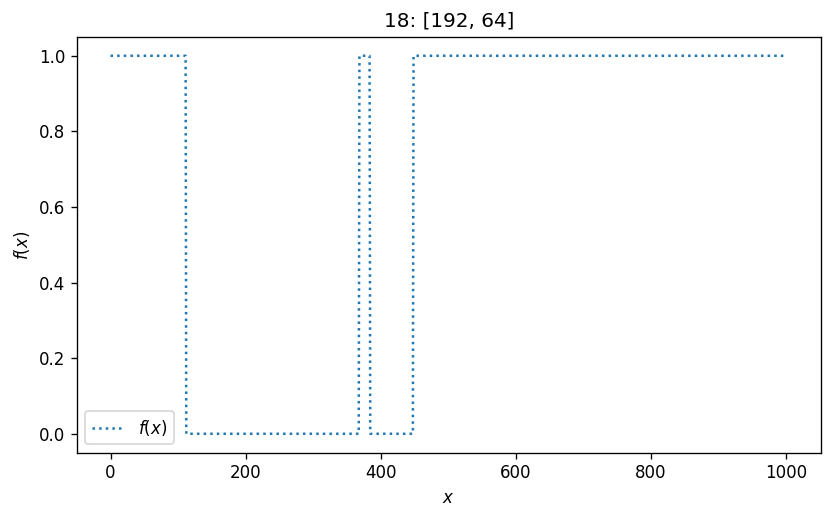

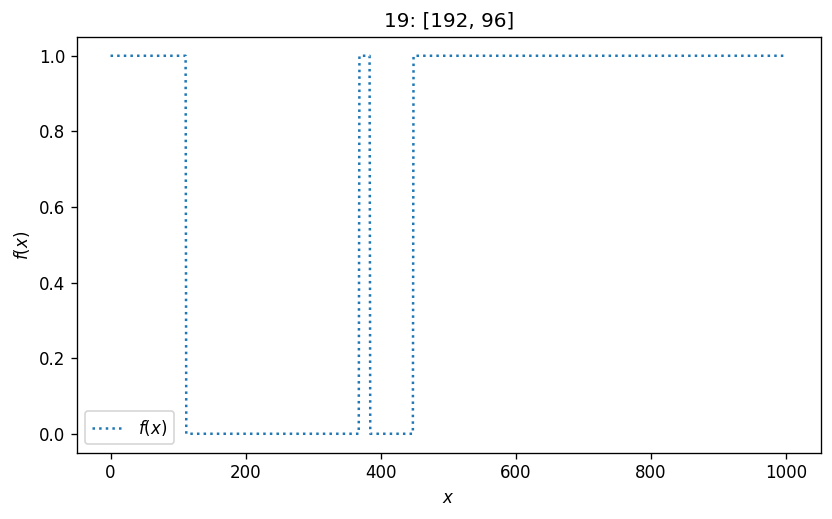

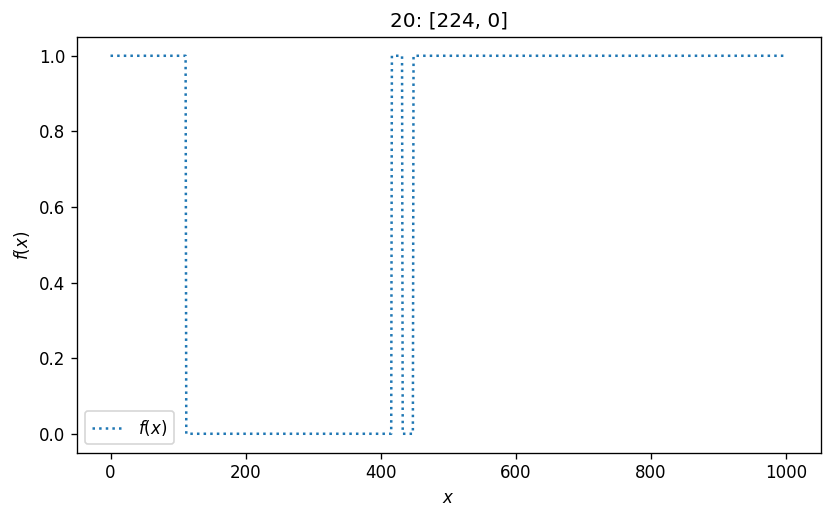

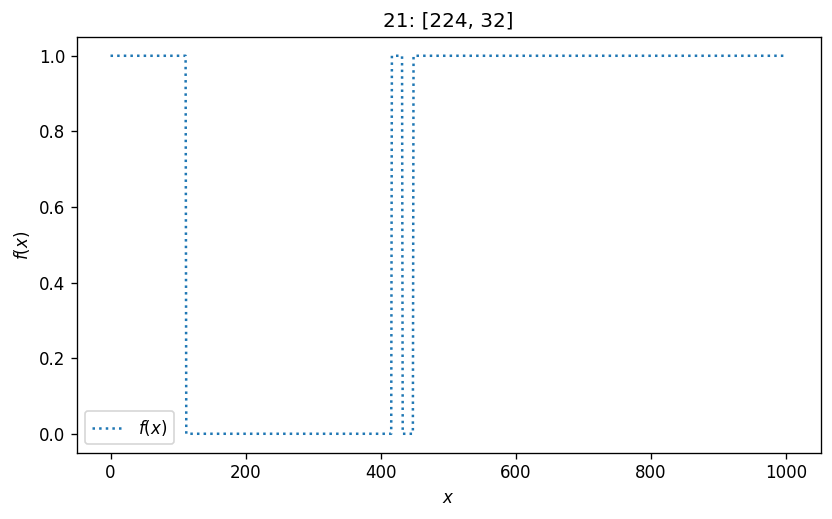

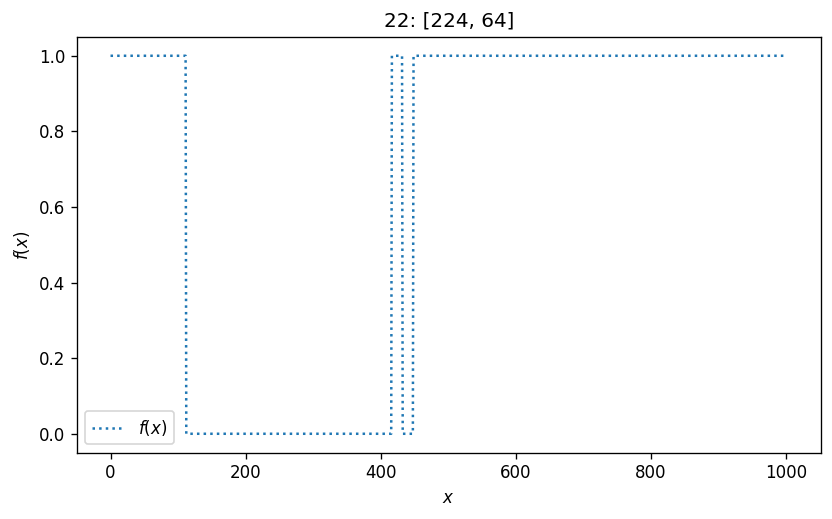

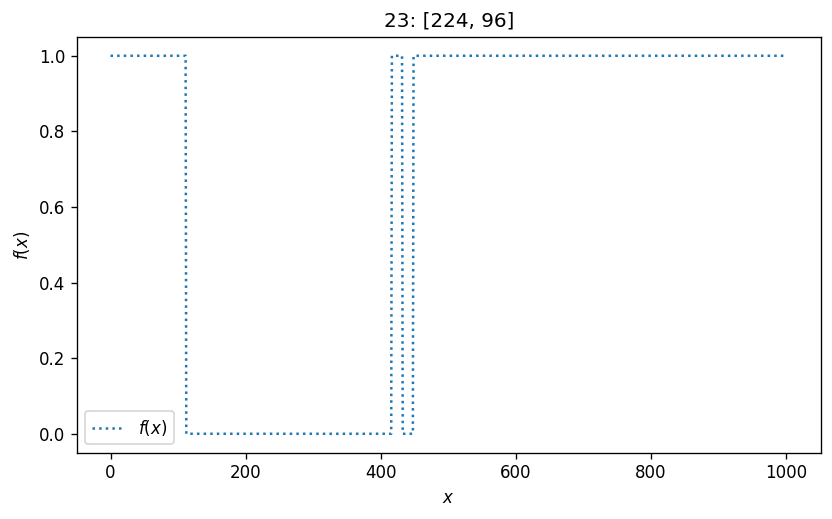

In [75]:
maxIJ = np.where(ZZ == np.max(ZZ))
X = np.linspace(start=0, stop=1001, num=1001).reshape(-1, 1)
#print(X.shape)

for point in range(maxIJ[0].shape[0]):
    y = np.squeeze(Z[:, maxIJ[0][point], maxIJ[1][point]])
    #print(y.shape)
    factor = 0.5
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(16*factor, 9*factor), dpi=(1920/16)) #  72 is the nominal DPI

    plt.plot(X, y, label=r"$f(x)$", linestyle="dotted")
    plt.legend()
    plt.xlabel("$x$")
    plt.ylabel("$f(x)$")
    _ = plt.title(f'{point}: {[maxIJ[0][point], maxIJ[1][point]]}')


In [76]:
point = 11
y = np.squeeze(Z[:, maxIJ[0][point], maxIJ[1][point]])

In [77]:
rng = np.random.RandomState(1)
training_indices = rng.choice(np.arange(y.size), size=16, replace=False)
X_train, y_train = X[training_indices], y[training_indices]

In [78]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared

#kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-3, 1e3))
kernel = ExpSineSquared(length_scale=0.5, periodicity=1.0, length_scale_bounds=(1e-07, 1e+07), periodicity_bounds=(1e-06, 1e+06))

gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gaussian_process.fit(X_train, y_train)
gaussian_process.kernel_

ExpSineSquared(length_scale=0.000801, periodicity=4.09e+05)

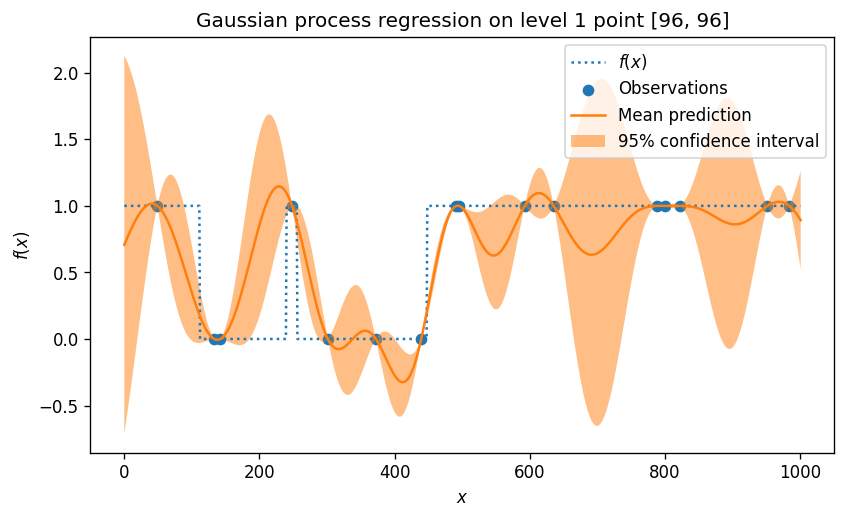

In [80]:
mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)
fig = plt.figure(figsize=(16*factor, 9*factor), dpi=(1920/16)) #  72 is the nominal DPI

plt.plot(X, y, label=r"$f(x)$", linestyle="dotted")
plt.scatter(X_train, y_train, label="Observations")
plt.plot(X, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$t = step$")
plt.ylabel("$f(t)$")
_ = plt.title(f"Gaussian process regression on level 1 point {[maxIJ[0][point], maxIJ[1][point]]}")